In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nephased-datasets/__results__.html
/kaggle/input/nephased-datasets/__notebook__.ipynb
/kaggle/input/nephased-datasets/__output__.json
/kaggle/input/nephased-datasets/custom.css
/kaggle/input/nephased-datasets/torch_datasets/train.pt
/kaggle/input/nephased-datasets/torch_datasets/val.pt
/kaggle/input/nephased-datasets/torch_datasets/test.pt
/kaggle/input/nephased-datasets/torch_datasets/datasets.py
/kaggle/input/nephased-datasets/torch_datasets/__pycache__/datasets.cpython-311.pyc
/kaggle/input/nephased-datasets/__results___files/__results___7_1.png
/kaggle/input/nephased-datasets/__results___files/__results___6_0.png
/kaggle/input/nephased-datasets/hf_datasets/dataset/dataset_dict.json
/kaggle/input/nephased-datasets/hf_datasets/dataset/validation/state.json
/kaggle/input/nephased-datasets/hf_datasets/dataset/validation/dataset_info.json
/kaggle/input/nephased-datasets/hf_datasets/dataset/validation/data-00000-of-00001.arrow
/kaggle/input/nephased-datasets/hf_datasets/dat

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report, average_precision_score, ConfusionMatrixDisplay
from pathlib import Path
import shutil

# # Custom Dataset function
# Path("./custom_dataset").mkdir()
# shutil.copy(Path("/kaggle/input/nephased-datasets/torch_datasets/datasets.py"), Path("./custom_dataset/"))
from custom_dataset.datasets import SequenceDataset

# Embedding Model Paths
scratch_path = "/kaggle/input/word2vec/scratch/scratch.txt"
pretrained_path = "/kaggle/input/pretrained-fasttext/pretrained_word2vec/pretrained_word2vec.txt"
finetuned_path = "/kaggle/input/word2vec/output/finetuned.txt"

In [10]:
# Loading the embedders
scratch = KeyedVectors.load_word2vec_format(scratch_path, binary=False)
pretrained = KeyedVectors.load_word2vec_format(pretrained_path, binary=False)
finetuned = KeyedVectors.load_word2vec_format(finetuned_path, binary=False)

print(pretrained["ठोक"])

[ 1.16097584e-01  1.21675901e-01  1.60100088e-01  5.61251976e-02
  1.67009998e-02  2.17907026e-01 -5.28010316e-02  1.05651058e-01
 -2.46215418e-01 -5.97307980e-02 -5.51273078e-02  1.00536095e-02
  1.42374054e-01 -1.42824039e-01  1.17562599e-01  1.86187312e-01
 -6.15408011e-02 -1.55087009e-01 -1.49622664e-01 -1.61983475e-01
  3.05289268e-01 -1.19407857e-02  8.36925134e-02 -1.44923344e-01
  1.39418049e-02 -1.25078540e-02 -1.04307301e-01 -3.06585491e-01
 -2.08911337e-02 -4.69857976e-02  6.40568733e-02 -1.60351265e-02
  2.65532304e-02  3.50164734e-02  5.48290052e-02  1.83446154e-01
  3.11760232e-02  1.19463205e-01 -8.01653266e-02  1.79191962e-01
 -8.16246495e-02  6.87548816e-02  2.56259799e-01  2.52241697e-02
 -1.14869162e-01  9.08422768e-02 -5.64455464e-02 -1.13432974e-01
 -1.10583575e-02 -2.33615443e-01 -6.63544331e-03 -8.00742656e-02
  9.98703465e-02 -5.80891222e-02 -9.77014527e-02 -5.18923346e-03
  8.46014544e-02 -1.17708324e-02  1.95811525e-01  1.10150576e-01
  3.99903506e-02  1.03105

In [17]:
# Pad Token
PAD_TOKEN = "<pad>"

# In W2V models' text file
def add_pad_to_word2vec_model(model, pad_token="<pad>"):
    if pad_token not in model.key_to_index:
        model.add_vector(pad_token, np.zeros(model.vector_size))

add_pad_to_word2vec_model(scratch)
add_pad_to_word2vec_model(pretrained)
add_pad_to_word2vec_model(finetuned)

/usr/local/lib/python3.11/dist-packages/gensim/models/keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


In [18]:
# Getting the Dataset
train = torch.load("/kaggle/input/nephased-datasets/torch_datasets/train.pt")
test = torch.load("/kaggle/input/nephased-datasets/torch_datasets/test.pt")
val = torch.load("/kaggle/input/nephased-datasets/torch_datasets/val.pt")

print(len(train["sentences"]))
print(test["sentences"][0])
print(len(test["labels"]))

3765
['गोलि', 'हान्यो', 'तिर्थ', 'लाइ', 'प्रहरी', 'चोर', 'होश', 'प्रबक्ता', '।']
471


For Word2Vec model we cannot enter padsequence zero vector as sub word generation will create non-zero vector which contradicts our implementations on masking

In [19]:
# Using custom dataset to get vectors for our tokens
scratch_train = SequenceDataset(train["sentences"], binary=False, model=scratch, labels=train["labels"])
scratch_test = SequenceDataset(test["sentences"], binary=False, model=scratch, labels=test["labels"])
scratch_val = SequenceDataset(val["sentences"], binary=False, model=scratch, labels=val["labels"])

pretrained_train = SequenceDataset(train["sentences"], binary=False, model=pretrained, labels=train["labels"])
pretrained_test = SequenceDataset(test["sentences"], binary=False, model=pretrained, labels=test["labels"])
pretrained_val = SequenceDataset(val["sentences"], binary=False, model=pretrained, labels=val["labels"])

finetuned_train = SequenceDataset(train["sentences"], binary=False, model=finetuned, labels=train["labels"])
finetuned_test = SequenceDataset(test["sentences"], binary=False, model=finetuned, labels=test["labels"])
finetuned_val = SequenceDataset(val["sentences"], binary=False, model=finetuned, labels=val["labels"])



In [20]:
print(pretrained_val[0])
print(finetuned_test[0][0])

(tensor([[ 0.0875, -0.1474, -0.0618,  ..., -0.0456,  0.1638, -0.0472],
        [ 2.3340, -1.1014,  0.6003,  ...,  1.2910,  0.3907, -0.0846],
        [ 0.2034, -0.0470,  0.1023,  ...,  0.1294, -0.1370, -0.0748],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]), tensor([ True,  True,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, Fal

/kaggle/working/custom_dataset/datasets.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  torch.tensor(vectors, dtype=torch.float32),


In [21]:
print(scratch_train[0][0].shape)

torch.Size([100, 300])


In [22]:
print(len(scratch_train))
print(len(scratch_test))

3765
471


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [24]:
sequence_length, embeddings_size= scratch_train[0][0].shape
print(sequence_length)

100


## Model Definition

In [25]:
class BiLSTMAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.5):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim,num_layers=1, batch_first=True, bidirectional=True)
        self.ln = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout)
        self.attn = nn.Linear(hidden_dim * 2, 1) # since BiLSTM
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x, mask):
        lstm_out, _ = self.lstm(x)  # (Batch, SequenceLength, 2 * Hidden Dim)
        lstm_out = self.ln(lstm_out)  # Normalize
        lstm_out = self.dropout(lstm_out)  # Dropout

        # Attention scores
        scores = self.attn(lstm_out).squeeze(-1)  # (B, L)

        # Mask padding positions
        scores = scores.masked_fill(~mask, float('-inf'))  # invalid positions → -inf

        attn_weights = torch.softmax(scores, dim=1)  # (B, L)
        attn_weights = attn_weights.unsqueeze(-1)   # (B, L, 1)

        # Weighted sum
        context = torch.sum(attn_weights * lstm_out, dim=1)  # (B, 2H)
        context = self.ln(context) # normalize before FC
        logits = self.fc(context)  # (B, num_classes)

        return logits, attn_weights

## Training Function

In [26]:
def model_train(model, criterion, optimizer, train_loader, val_loader, save_name=None, version_control=False, epochs=20):
    import matplotlib.pyplot as plt
    import copy

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    best_val_loss = float('inf')
    best_epoch = 0
    best_model_weights = None

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for X_batch, mask, y_batch in train_loader:
            X_batch, mask, y_batch = X_batch.to(device), mask.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs, _ = model(X_batch, mask)
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct / total)

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for X_batch, mask, y_batch in val_loader:
                X_batch, mask, y_batch = X_batch.to(device), mask.to(device), y_batch.to(device)
                outputs, _ = model(X_batch, mask)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

                preds = outputs.argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)

        current_val_loss = val_loss / len(val_loader)
        val_losses.append(current_val_loss)
        val_accuracies.append(correct / total)

        # Update best model
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            best_epoch = epoch + 1 
            best_model_weights = copy.deepcopy(model.state_dict())

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | "
              f"Train Acc: {train_accuracies[-1]*100:.2f}% | Val Acc: {val_accuracies[-1]*100:.2f}%")

    # Plotting with vertical dotted line for best epoch
    plt.figure(figsize=(14, 6))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
    plt.axvline(x=best_epoch, color='red', linestyle=':', 
                label=f'Best Epoch: {best_epoch}\nVal Loss: {best_val_loss:.4f}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), train_accuracies, label='Train Acc')
    plt.plot(range(1, epochs+1), val_accuracies, label='Val Acc')
    plt.axvline(x=best_epoch, color='red', linestyle=':', 
                label=f'Best Epoch: {best_epoch}\nVal Acc: {val_accuracies[best_epoch-1]*100:.2f}%')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    if version_control:
        plt.savefig(f"/kaggle/working/{save_name}_loss.png", bbox_inches='tight', dpi=300)
    plt.show()

    # Load best model weights
    model.load_state_dict(best_model_weights)
    
    return model

## Training Model on Scratch Dataset

In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [28]:

def evaluate_model(model, test_loader, label_map=None, version_control= False, save_name = None):
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for X_batch, mask, y_batch in test_loader:
            X_batch, mask, y_batch = X_batch.to(device), mask.to(device), y_batch.to(device) 
            outputs, _ = model(X_batch, mask)
            probs = torch.softmax(outputs, dim=1)  # Shape: (batch_size, num_classes)
            preds = torch.argmax(probs, dim=1)

            all_labels.extend(y_batch.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    num_classes = all_probs.shape[1]

    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))

    # PR Curve for each class
    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(all_labels == i, all_probs[:, i])
        avg_precision = average_precision_score(all_labels == i, all_probs[:, i])
        if not label_map:
            plt.plot(recall, precision, label=f'Class {i} (AP = {avg_precision:.2f})')
        else:
            plt.plot(recall, precision, label=f'{label_map[i]} (AP = {avg_precision:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (Per-Class)')
    plt.legend(loc='upper right')
    plt.grid()
    if version_control:
        plt.savefig(f"/kaggle/working/{save_name}_PR.png", bbox_inches='tight', dpi=300)
    plt.show()

    # Confusion Matrix 
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 8))
    
    if not label_map:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(all_labels))
    else:
        labels = [label_map[i] for i in sorted(label_map.keys())]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
    plt.title('Confusion Matrix', pad=20, fontsize=14)
    
    # Rotate x-axis labels and adjust layout
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
    plt.yticks(rotation=0)
    plt.tight_layout() 
    plt.grid(False)
    plt.gca().set_facecolor('#f8f8f8')  
    if version_control:
        plt.savefig(f"/kaggle/working/{save_name}_cm.png", bbox_inches='tight', dpi=300)
    
    plt.show()

    if version_control:
        return classification_report(all_labels, all_preds, output_dict=True)

In [29]:
class LabelModifiedDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
        self.label_mapping = {
            0: 0,
            1: 0,
            2: 1,
            3: 2,
            4: 3,
            5: 3
        }
    
    def __len__(self):
        return len(self.original_dataset)
    
    def __getitem__(self, idx):
        item = self.original_dataset[idx]
        
        features, mask, label = item
        
        # Apply the specific mapping rules
        original_label = label.item()
        new_label = self.label_mapping.get(original_label, original_label)      
        
        return (features, mask, torch.tensor(new_label, dtype=label.dtype))

scratch_train = LabelModifiedDataset(scratch_train)
scratch_test = LabelModifiedDataset(scratch_test)
scratch_val = LabelModifiedDataset(scratch_val)

pretrained_train = LabelModifiedDataset(pretrained_train)
pretrained_test = LabelModifiedDataset(pretrained_test)
pretrained_val = LabelModifiedDataset(pretrained_val)

finetuned_train = LabelModifiedDataset(finetuned_train)
finetuned_test = LabelModifiedDataset(finetuned_test)
finetuned_val = LabelModifiedDataset(finetuned_val)


In [30]:
# 300 embeddings size with a hidden state output of 128 dim
scratch_params = {
    "input_dim" : 300,
    "hidden_dim" : 148,
    "num_classes" : 4,
    "lr" : 1e-4,
    "weight_decay" : 1e-5,
    "train_batch_size" : 16,
    "test_batch_size" : 16,
    "val_batch_size" : 16,
    "dropout": 0.5
}

scratch_model = BiLSTMAttention(
    input_dim=scratch_params["input_dim"],
    hidden_dim=scratch_params["hidden_dim"],
    num_classes=scratch_params["num_classes"],
    dropout = scratch_params["dropout"]
).to(device)

# Loss function
scratch_criterion = nn.CrossEntropyLoss()

# Optimizer using unpacking
scratch_optimizer = torch.optim.AdamW(
    scratch_model.parameters(),
    lr=scratch_params["lr"],
    weight_decay=scratch_params["weight_decay"]
)

print(scratch_model)

BiLSTMAttention(
  (lstm): LSTM(300, 148, batch_first=True, bidirectional=True)
  (ln): LayerNorm((296,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (attn): Linear(in_features=296, out_features=1, bias=True)
  (fc): Linear(in_features=296, out_features=4, bias=True)
)


In [31]:
# Setting up DataLoaders using scratch_params
scratch_train_loader = DataLoader(scratch_train, batch_size=scratch_params["train_batch_size"], shuffle=True, pin_memory=True)
scratch_test_loader  = DataLoader(scratch_test,  batch_size=scratch_params["test_batch_size"],  shuffle=True, pin_memory=True)
scratch_val_loader   = DataLoader(scratch_val,   batch_size=scratch_params["val_batch_size"],   shuffle=True, pin_memory=True)

pretrained_train_loader = DataLoader(pretrained_train, batch_size=scratch_params["train_batch_size"], shuffle=True, pin_memory=True)
pretrained_test_loader  = DataLoader(pretrained_test,  batch_size=scratch_params["test_batch_size"],  shuffle=True, pin_memory=True)
pretrained_val_loader   = DataLoader(pretrained_val,   batch_size=scratch_params["val_batch_size"],   shuffle=True, pin_memory=True)

finetuned_train_loader = DataLoader(finetuned_train, batch_size=scratch_params["train_batch_size"], shuffle=True, pin_memory=True)
finetuned_test_loader  = DataLoader(finetuned_test,  batch_size=scratch_params["test_batch_size"],  shuffle=True, pin_memory=True)
finetuned_val_loader   = DataLoader(finetuned_val,   batch_size=scratch_params["val_batch_size"],   shuffle=True, pin_memory=True)

Epoch 1/20 | Train Loss: 0.7845 | Val Loss: 0.6462 | Train Acc: 68.92% | Val Acc: 73.67%
Epoch 2/20 | Train Loss: 0.5772 | Val Loss: 0.6142 | Train Acc: 79.12% | Val Acc: 77.71%
Epoch 3/20 | Train Loss: 0.5296 | Val Loss: 0.5828 | Train Acc: 80.88% | Val Acc: 78.13%
Epoch 4/20 | Train Loss: 0.5046 | Val Loss: 0.5867 | Train Acc: 82.31% | Val Acc: 79.41%
Epoch 5/20 | Train Loss: 0.4834 | Val Loss: 0.5919 | Train Acc: 82.84% | Val Acc: 78.34%
Epoch 6/20 | Train Loss: 0.4685 | Val Loss: 0.5832 | Train Acc: 83.61% | Val Acc: 79.19%
Epoch 7/20 | Train Loss: 0.4600 | Val Loss: 0.5721 | Train Acc: 84.14% | Val Acc: 79.41%
Epoch 8/20 | Train Loss: 0.4495 | Val Loss: 0.5773 | Train Acc: 84.36% | Val Acc: 81.10%
Epoch 9/20 | Train Loss: 0.4308 | Val Loss: 0.5861 | Train Acc: 85.23% | Val Acc: 78.98%
Epoch 10/20 | Train Loss: 0.4311 | Val Loss: 0.5576 | Train Acc: 84.97% | Val Acc: 80.89%
Epoch 11/20 | Train Loss: 0.4195 | Val Loss: 0.5575 | Train Acc: 85.23% | Val Acc: 81.32%
Epoch 12/20 | Train

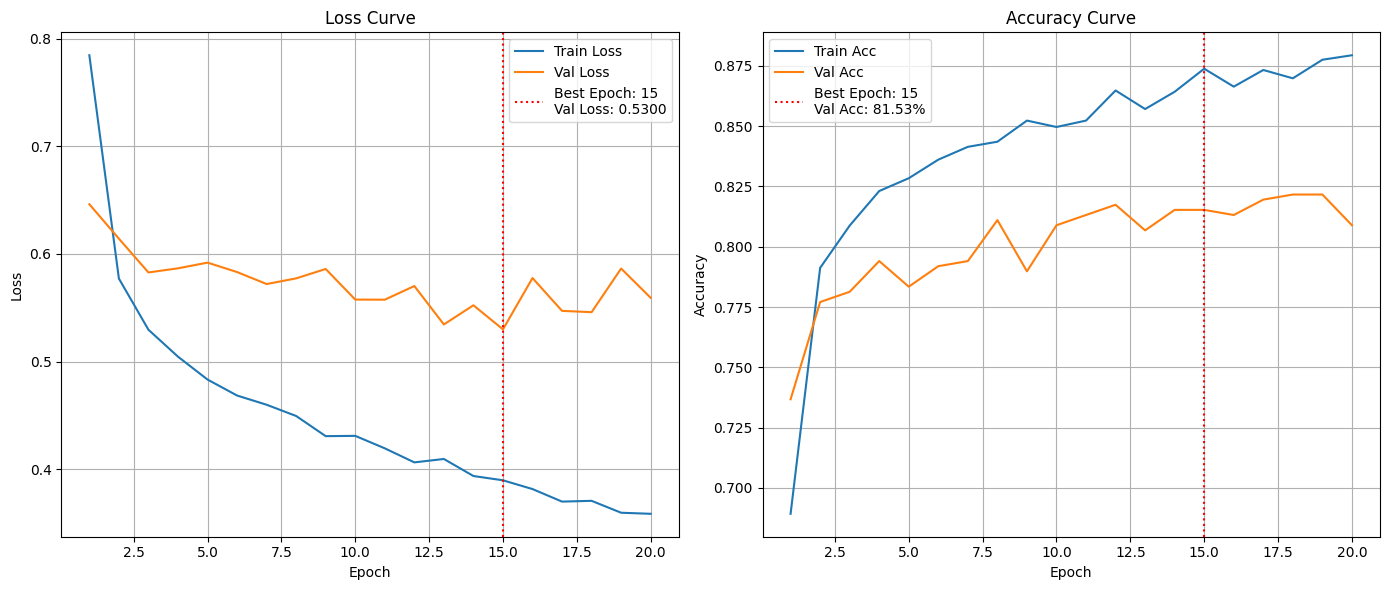

In [32]:
scratch_model = model_train(scratch_model, scratch_criterion, scratch_optimizer, scratch_train_loader, scratch_val_loader,save_name="Word2Vec_scratch", version_control=True,epochs= 20)

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       190
           1       0.71      0.71      0.71        94
           2       0.81      0.77      0.79        60
           3       0.82      0.76      0.79       127

    accuracy                           0.82       471
   macro avg       0.80      0.79      0.79       471
weighted avg       0.81      0.82      0.81       471



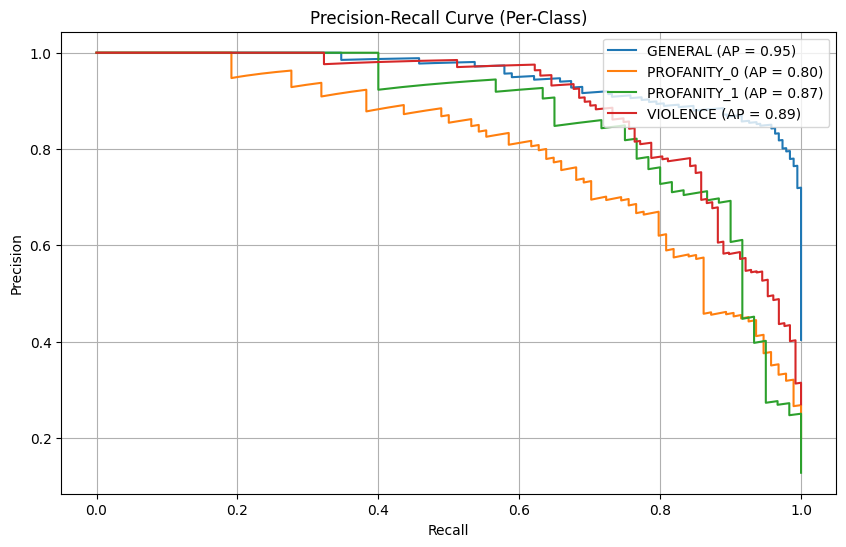

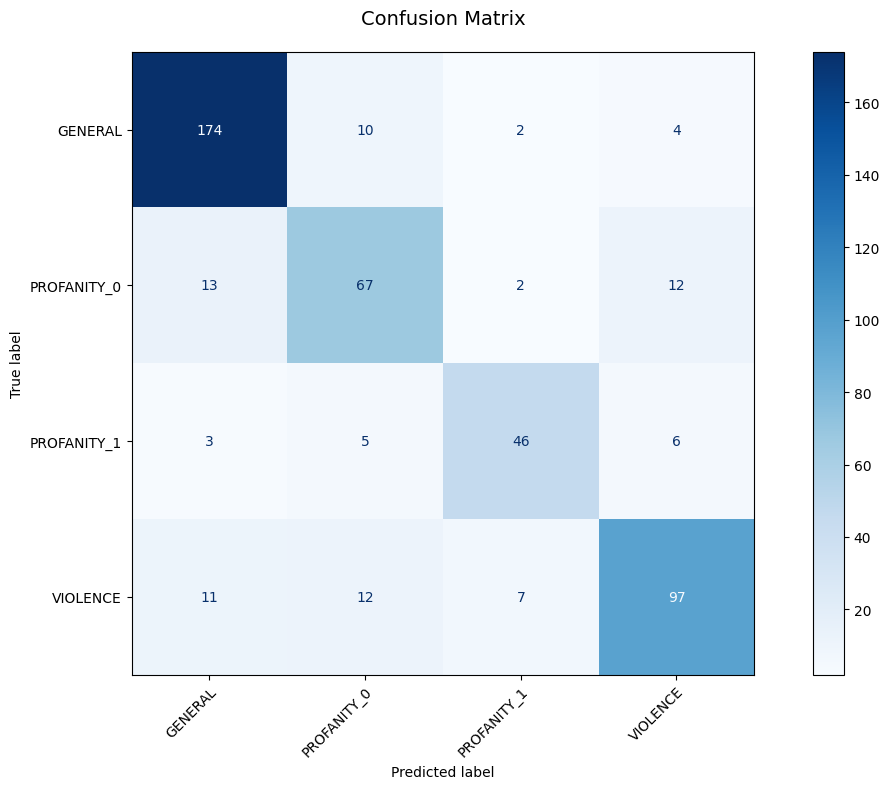

In [33]:
label_map = {
    0: 'GENERAL',
    1: 'PROFANITY_0',
    2: 'PROFANITY_1',
    3: 'VIOLENCE'
}

scratch_report = evaluate_model(scratch_model, scratch_val_loader, label_map,  version_control= True, save_name = "Word2Vec_scratch")

In [34]:
scratch_report

{'0': {'precision': 0.8656716417910447,
  'recall': 0.9157894736842105,
  'f1-score': 0.8900255754475703,
  'support': 190},
 '1': {'precision': 0.7127659574468085,
  'recall': 0.7127659574468085,
  'f1-score': 0.7127659574468085,
  'support': 94},
 '2': {'precision': 0.8070175438596491,
  'recall': 0.7666666666666667,
  'f1-score': 0.7863247863247863,
  'support': 60},
 '3': {'precision': 0.8151260504201681,
  'recall': 0.7637795275590551,
  'f1-score': 0.7886178861788617,
  'support': 127},
 'accuracy': 0.8152866242038217,
 'macro avg': {'precision': 0.8001452983794175,
  'recall': 0.7897504063391851,
  'f1-score': 0.7944335513495067,
  'support': 471},
 'weighted avg': {'precision': 0.8140545073784262,
  'recall': 0.8152866242038217,
  'f1-score': 0.8140951551151612,
  'support': 471}}

## Pre-trained Model

In [35]:
pretrained_params = {
    "input_dim" : 300,
    "hidden_dim" : 148,
    "num_classes" : 4,
    "lr" : 1e-4,
    "weight_decay" : 1e-5,
    "train_batch_size" : 16,
    "test_batch_size" : 16,
    "val_batch_size" : 16,
    "dropout": 0.5
}

pretrained_model = BiLSTMAttention(
    input_dim=pretrained_params["input_dim"],
    hidden_dim=pretrained_params["hidden_dim"],
    num_classes=pretrained_params["num_classes"]
).to(device)

# Loss function
pretrained_criterion = nn.CrossEntropyLoss()

# Optimizer using unpacking
pretrained_optimizer = torch.optim.AdamW(
    pretrained_model.parameters(),
    lr=pretrained_params["lr"],
    weight_decay=pretrained_params["weight_decay"]
)

print(pretrained_model)

BiLSTMAttention(
  (lstm): LSTM(300, 148, batch_first=True, bidirectional=True)
  (ln): LayerNorm((296,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (attn): Linear(in_features=296, out_features=1, bias=True)
  (fc): Linear(in_features=296, out_features=4, bias=True)
)


Epoch 1/20 | Train Loss: 0.9983 | Val Loss: 0.7934 | Train Acc: 62.02% | Val Acc: 67.73%
Epoch 2/20 | Train Loss: 0.7476 | Val Loss: 0.7410 | Train Acc: 72.27% | Val Acc: 71.97%
Epoch 3/20 | Train Loss: 0.6420 | Val Loss: 0.7096 | Train Acc: 76.20% | Val Acc: 72.82%
Epoch 4/20 | Train Loss: 0.5726 | Val Loss: 0.6942 | Train Acc: 79.65% | Val Acc: 73.46%
Epoch 5/20 | Train Loss: 0.5140 | Val Loss: 0.7080 | Train Acc: 81.35% | Val Acc: 74.73%
Epoch 6/20 | Train Loss: 0.4571 | Val Loss: 0.7223 | Train Acc: 84.20% | Val Acc: 74.31%
Epoch 7/20 | Train Loss: 0.4051 | Val Loss: 0.7338 | Train Acc: 85.98% | Val Acc: 74.31%
Epoch 8/20 | Train Loss: 0.3586 | Val Loss: 0.8064 | Train Acc: 87.44% | Val Acc: 73.67%
Epoch 9/20 | Train Loss: 0.3219 | Val Loss: 0.8306 | Train Acc: 88.92% | Val Acc: 73.89%
Epoch 10/20 | Train Loss: 0.2820 | Val Loss: 0.8115 | Train Acc: 90.44% | Val Acc: 74.52%
Epoch 11/20 | Train Loss: 0.2393 | Val Loss: 0.8954 | Train Acc: 92.88% | Val Acc: 73.04%
Epoch 12/20 | Train

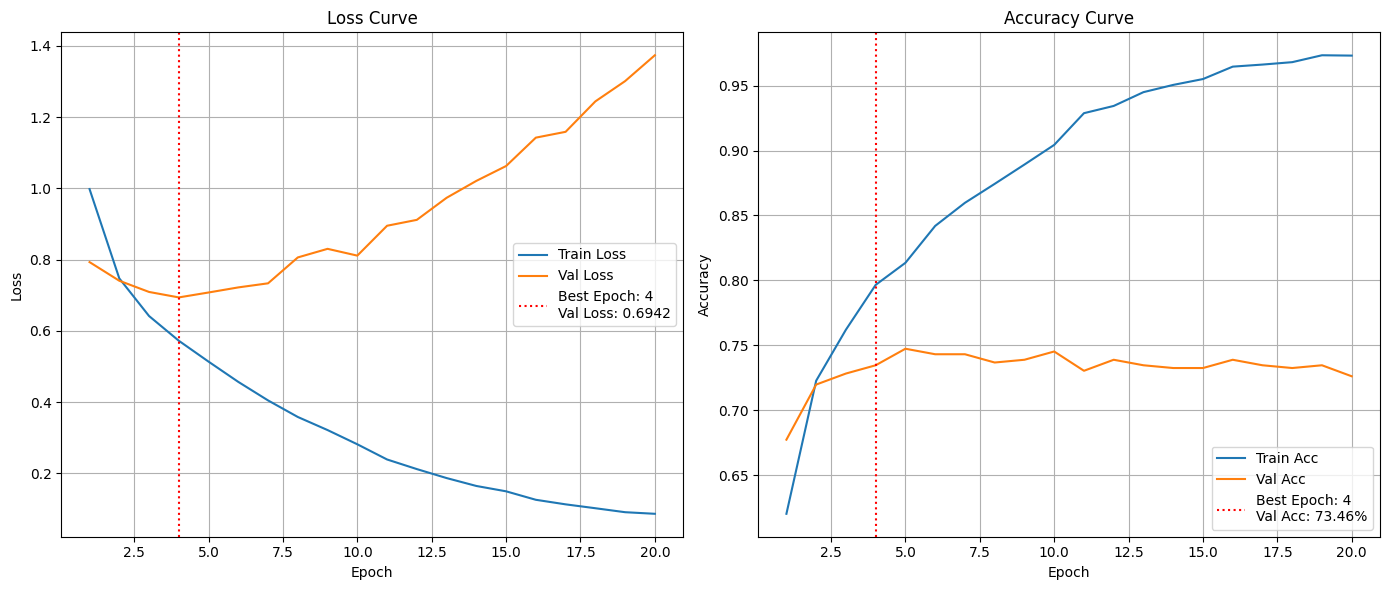

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.89      0.83       190
           1       0.62      0.60      0.61        94
           2       0.66      0.38      0.48        60
           3       0.77      0.76      0.77       127

    accuracy                           0.73       471
   macro avg       0.71      0.66      0.67       471
weighted avg       0.73      0.73      0.72       471



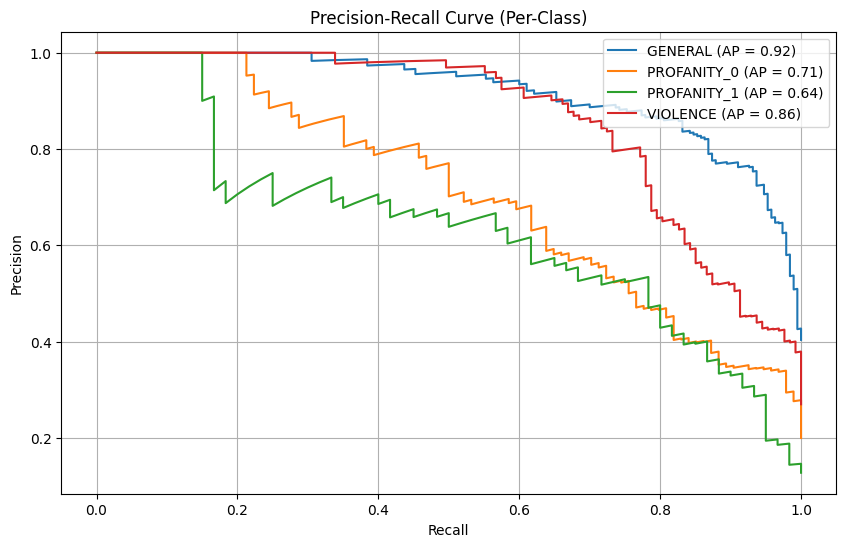

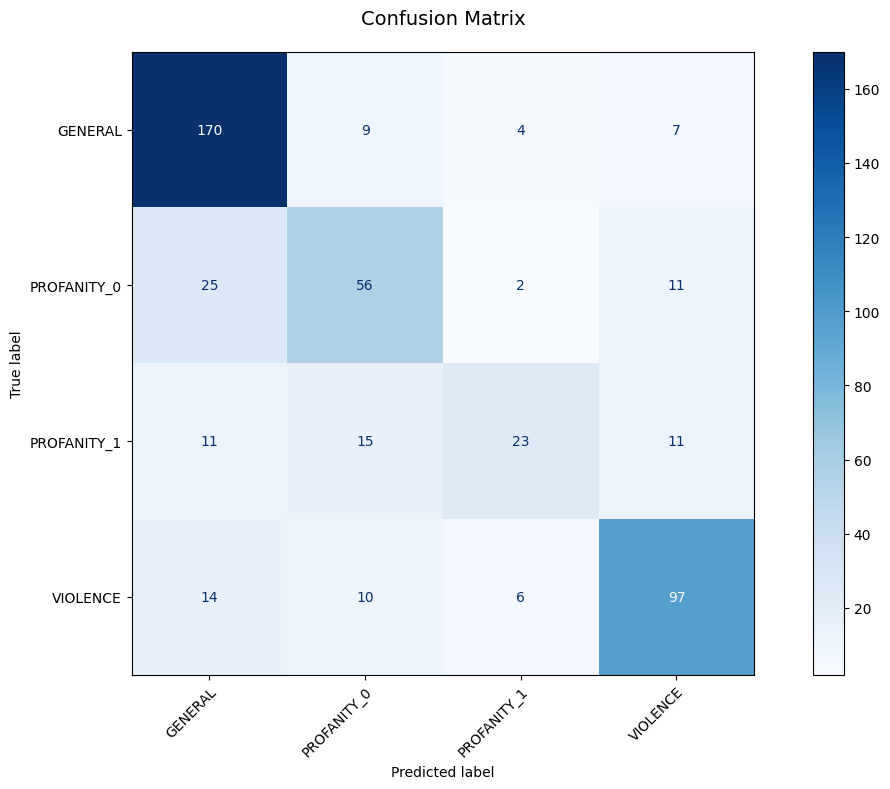

In [36]:
pretrained_model = model_train(pretrained_model, pretrained_criterion, pretrained_optimizer, pretrained_train_loader, pretrained_val_loader,save_name="Word2Vec_pretrained", version_control=True,epochs= 20)
pretrained_report = evaluate_model(pretrained_model, pretrained_val_loader, label_map,  version_control= True, save_name = "Word2Vec_pretrained")

## Finetuned Model

In [37]:
finetuned_params = {
    "input_dim" : 300,
    "hidden_dim" : 148,
    "num_classes" : 4,
    "lr" : 1e-4,
    "weight_decay" : 1e-5,
    "train_batch_size" : 16,
    "test_batch_size" : 16,
    "val_batch_size" : 16,
    "dropout": 0.5
}

finetuned_model = BiLSTMAttention(
    input_dim=finetuned_params["input_dim"],
    hidden_dim=finetuned_params["hidden_dim"],
    num_classes=finetuned_params["num_classes"]
).to(device)

# Loss function
finetuned_criterion = nn.CrossEntropyLoss()

# Optimizer using unpacking
finetuned_optimizer = torch.optim.AdamW(
    finetuned_model.parameters(),
    lr=finetuned_params["lr"],
    weight_decay=finetuned_params["weight_decay"]
)

print(finetuned_model)

BiLSTMAttention(
  (lstm): LSTM(300, 148, batch_first=True, bidirectional=True)
  (ln): LayerNorm((296,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (attn): Linear(in_features=296, out_features=1, bias=True)
  (fc): Linear(in_features=296, out_features=4, bias=True)
)


Epoch 1/20 | Train Loss: 0.9241 | Val Loss: 0.7459 | Train Acc: 63.96% | Val Acc: 73.89%
Epoch 2/20 | Train Loss: 0.6342 | Val Loss: 0.6082 | Train Acc: 76.73% | Val Acc: 80.04%
Epoch 3/20 | Train Loss: 0.5151 | Val Loss: 0.5817 | Train Acc: 81.09% | Val Acc: 80.47%
Epoch 4/20 | Train Loss: 0.4451 | Val Loss: 0.5588 | Train Acc: 84.62% | Val Acc: 80.89%
Epoch 5/20 | Train Loss: 0.3946 | Val Loss: 0.5935 | Train Acc: 86.99% | Val Acc: 79.83%
Epoch 6/20 | Train Loss: 0.3497 | Val Loss: 0.5628 | Train Acc: 88.31% | Val Acc: 81.10%
Epoch 7/20 | Train Loss: 0.3139 | Val Loss: 0.6010 | Train Acc: 89.64% | Val Acc: 81.95%
Epoch 8/20 | Train Loss: 0.2794 | Val Loss: 0.6168 | Train Acc: 90.73% | Val Acc: 80.47%
Epoch 9/20 | Train Loss: 0.2473 | Val Loss: 0.6378 | Train Acc: 91.93% | Val Acc: 79.62%
Epoch 10/20 | Train Loss: 0.2226 | Val Loss: 0.6586 | Train Acc: 92.59% | Val Acc: 81.74%
Epoch 11/20 | Train Loss: 0.1962 | Val Loss: 0.6973 | Train Acc: 93.71% | Val Acc: 80.68%
Epoch 12/20 | Train

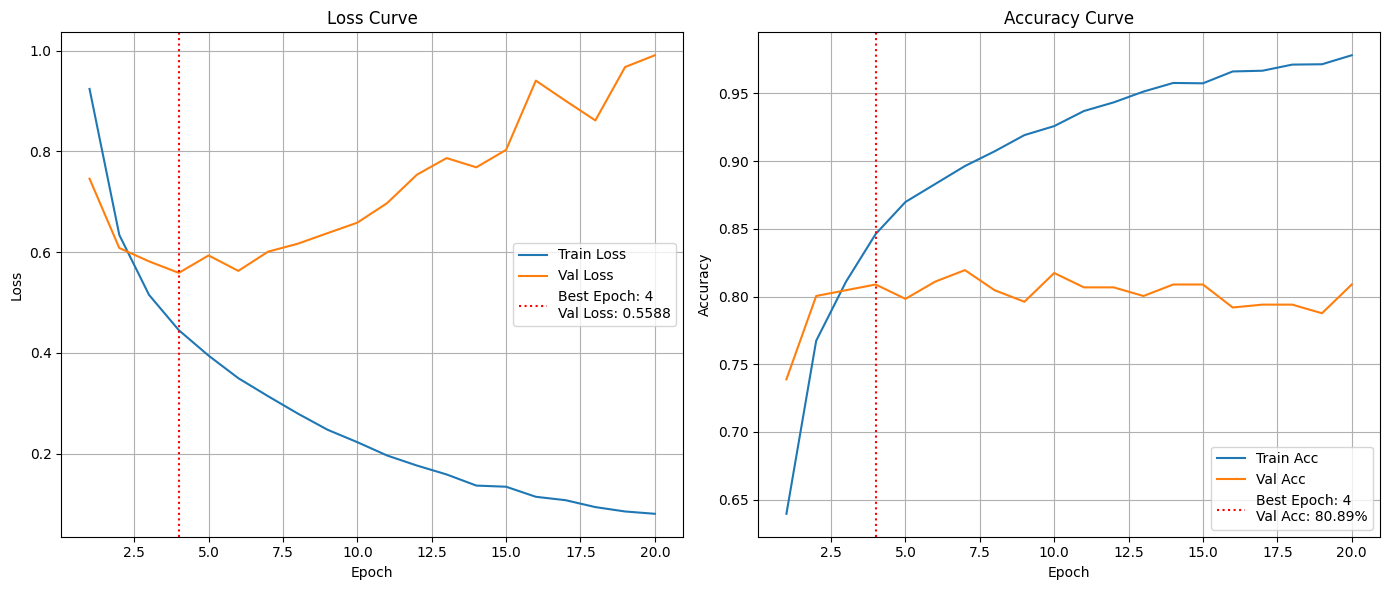

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       190
           1       0.79      0.67      0.72        94
           2       0.79      0.68      0.73        60
           3       0.80      0.76      0.78       127

    accuracy                           0.81       471
   macro avg       0.80      0.77      0.78       471
weighted avg       0.81      0.81      0.80       471



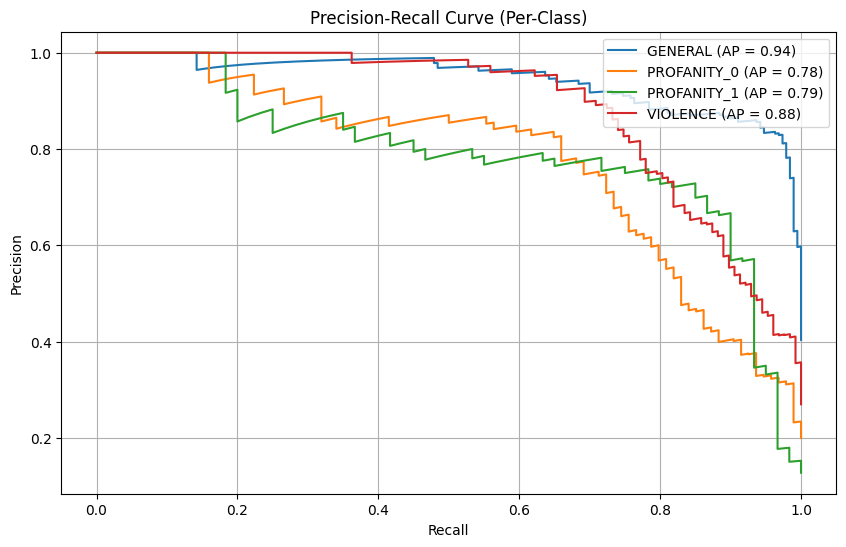

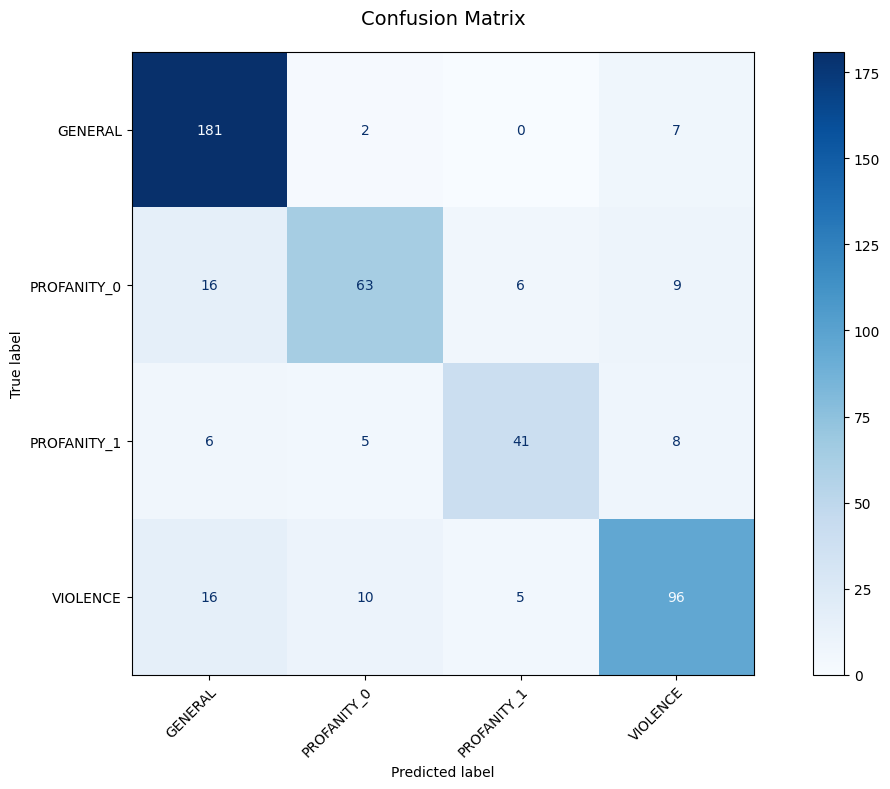

In [38]:
finetuned_model = model_train(finetuned_model, finetuned_criterion, finetuned_optimizer, finetuned_train_loader, finetuned_val_loader,save_name="Word2Vec_finetuned", version_control=True,epochs= 20)
finetuned_report = evaluate_model(finetuned_model, finetuned_val_loader, label_map,  version_control= True, save_name = "Word2Vec_finetuned")

## Also, let's check cost sensitive models with class weights

In [39]:
from sklearn.utils.class_weight import compute_class_weight

labels = []
for i in range(len(scratch_train)):
    _, _, label = scratch_train[i]  
    labels.append(label.item()) 

labels = np.array(labels)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',  # Automatically balances based on class frequencies
    classes=np.unique(labels),  # Unique classes in training labels
    y=labels  # Training labels
)
class_weights = class_weights / np.sum(class_weights) # Normalizing magnitude for proper gradient updates

# Convert class weights to a PyTorch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
print("Normalized Class Weights:", class_weights_tensor)

class_weights_tensor = class_weights_tensor.to(device)

Normalized Class Weights: tensor([0.1307, 0.2639, 0.4114, 0.1940])


Epoch 1/20 | Train Loss: 0.8890 | Val Loss: 0.7540 | Train Acc: 68.29% | Val Acc: 75.16%
Epoch 2/20 | Train Loss: 0.6451 | Val Loss: 0.6952 | Train Acc: 77.00% | Val Acc: 77.07%
Epoch 3/20 | Train Loss: 0.5876 | Val Loss: 0.6600 | Train Acc: 79.71% | Val Acc: 76.86%
Epoch 4/20 | Train Loss: 0.5495 | Val Loss: 0.6533 | Train Acc: 81.49% | Val Acc: 77.49%
Epoch 5/20 | Train Loss: 0.5302 | Val Loss: 0.6844 | Train Acc: 82.63% | Val Acc: 79.19%
Epoch 6/20 | Train Loss: 0.5154 | Val Loss: 0.6505 | Train Acc: 82.63% | Val Acc: 78.56%
Epoch 7/20 | Train Loss: 0.4969 | Val Loss: 0.6901 | Train Acc: 83.69% | Val Acc: 80.04%
Epoch 8/20 | Train Loss: 0.4774 | Val Loss: 0.6829 | Train Acc: 84.25% | Val Acc: 80.47%
Epoch 9/20 | Train Loss: 0.4792 | Val Loss: 0.6684 | Train Acc: 84.28% | Val Acc: 81.74%
Epoch 10/20 | Train Loss: 0.4616 | Val Loss: 0.6915 | Train Acc: 84.83% | Val Acc: 81.32%
Epoch 11/20 | Train Loss: 0.4508 | Val Loss: 0.6620 | Train Acc: 85.37% | Val Acc: 80.04%
Epoch 12/20 | Train

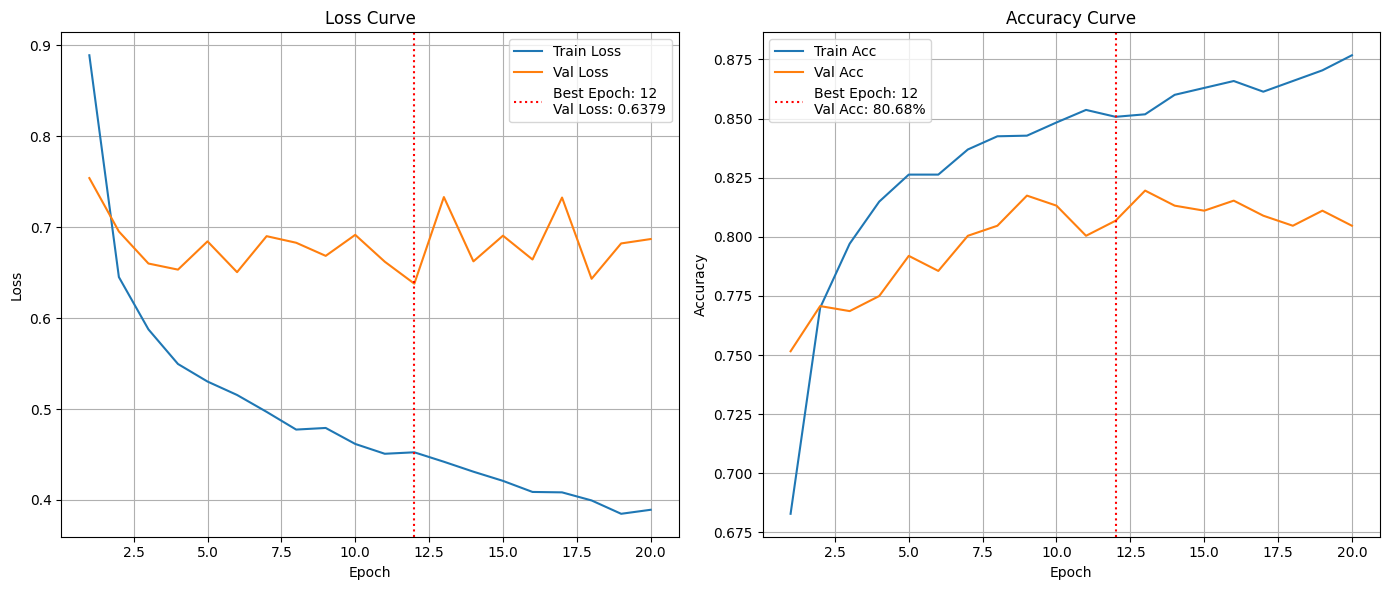

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       190
           1       0.64      0.80      0.71        94
           2       0.80      0.75      0.78        60
           3       0.87      0.72      0.79       127

    accuracy                           0.81       471
   macro avg       0.80      0.79      0.79       471
weighted avg       0.82      0.81      0.81       471



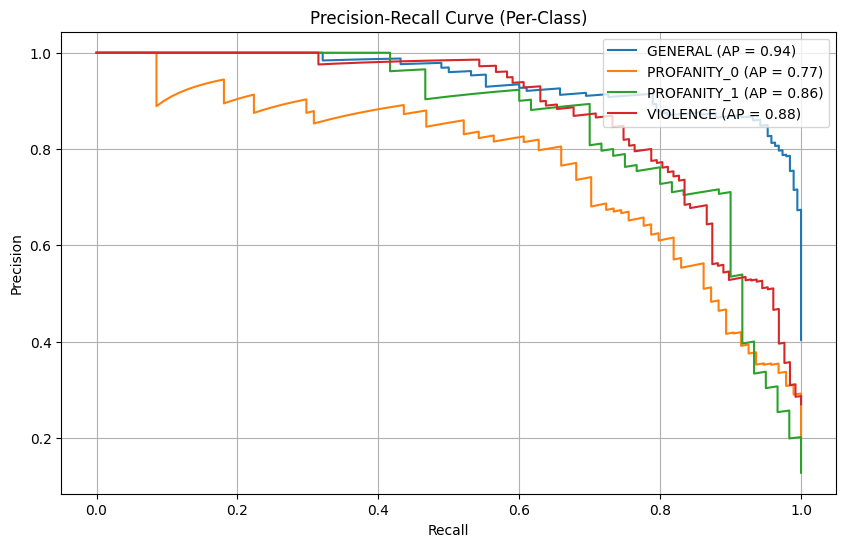

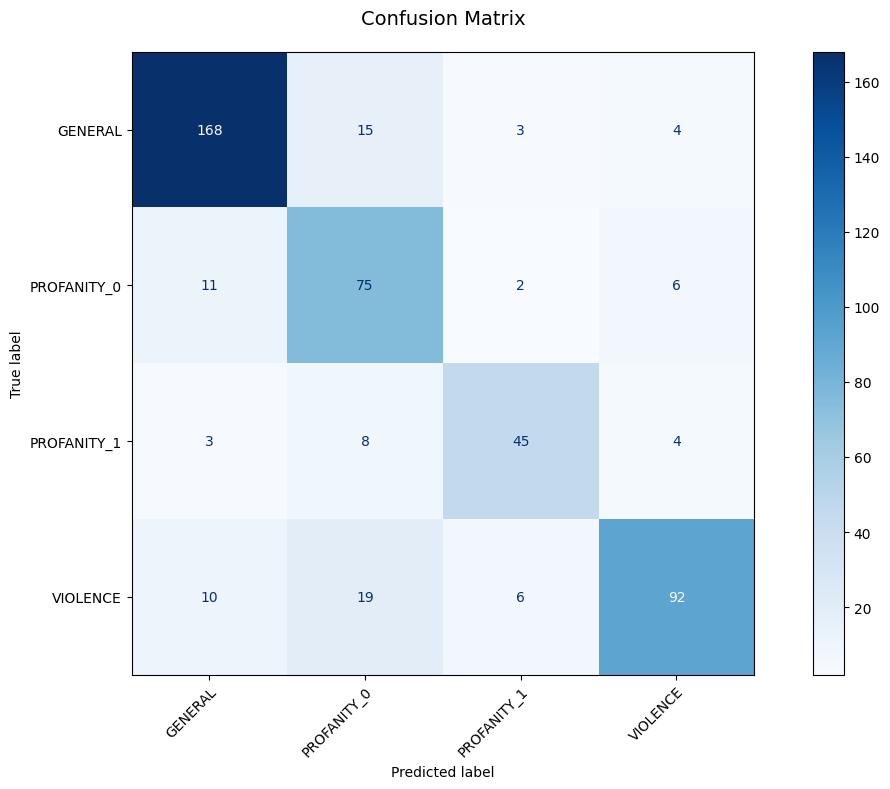

In [40]:
cs_scratch_params = {
    "input_dim" : 300,
    "hidden_dim" : 148,
    "num_classes" : 4,
    "lr" : 1e-4,
    "weight_decay" : 1e-5,
    "train_batch_size" : 16,
    "test_batch_size" : 16,
    "val_batch_size" : 16,
    "dropout": 0.5
}

cs_scratch_model = BiLSTMAttention(
    input_dim=cs_scratch_params["input_dim"],
    hidden_dim=cs_scratch_params["hidden_dim"],
    num_classes=cs_scratch_params["num_classes"]
).to(device)

# Loss function
cs_scratch_criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer using unpacking
cs_scratch_optimizer = torch.optim.AdamW(
    cs_scratch_model.parameters(),
    lr=cs_scratch_params["lr"],
    weight_decay=cs_scratch_params["weight_decay"]
)

cs_scratch_model = model_train(cs_scratch_model, cs_scratch_criterion, cs_scratch_optimizer, scratch_train_loader, scratch_val_loader,save_name="cs_Word2Vec_scratch", version_control=True,epochs= 20)
cs_scratch_report = evaluate_model(cs_scratch_model, scratch_val_loader, label_map,  version_control= True, save_name = "cs_Word2Vec_scratch")

Epoch 1/20 | Train Loss: 1.1093 | Val Loss: 0.8946 | Train Acc: 55.78% | Val Acc: 69.85%
Epoch 2/20 | Train Loss: 0.8327 | Val Loss: 0.8443 | Train Acc: 70.46% | Val Acc: 70.06%
Epoch 3/20 | Train Loss: 0.7165 | Val Loss: 0.8066 | Train Acc: 75.99% | Val Acc: 72.19%
Epoch 4/20 | Train Loss: 0.6341 | Val Loss: 0.8357 | Train Acc: 78.11% | Val Acc: 71.13%
Epoch 5/20 | Train Loss: 0.5608 | Val Loss: 0.8322 | Train Acc: 80.96% | Val Acc: 71.76%
Epoch 6/20 | Train Loss: 0.4926 | Val Loss: 0.8776 | Train Acc: 83.03% | Val Acc: 72.40%
Epoch 7/20 | Train Loss: 0.4356 | Val Loss: 0.9052 | Train Acc: 85.55% | Val Acc: 71.97%
Epoch 8/20 | Train Loss: 0.3882 | Val Loss: 0.9459 | Train Acc: 87.41% | Val Acc: 72.82%
Epoch 9/20 | Train Loss: 0.3435 | Val Loss: 0.9489 | Train Acc: 88.63% | Val Acc: 71.55%
Epoch 10/20 | Train Loss: 0.2936 | Val Loss: 1.0167 | Train Acc: 91.08% | Val Acc: 71.55%
Epoch 11/20 | Train Loss: 0.2493 | Val Loss: 1.0489 | Train Acc: 92.59% | Val Acc: 71.55%
Epoch 12/20 | Train

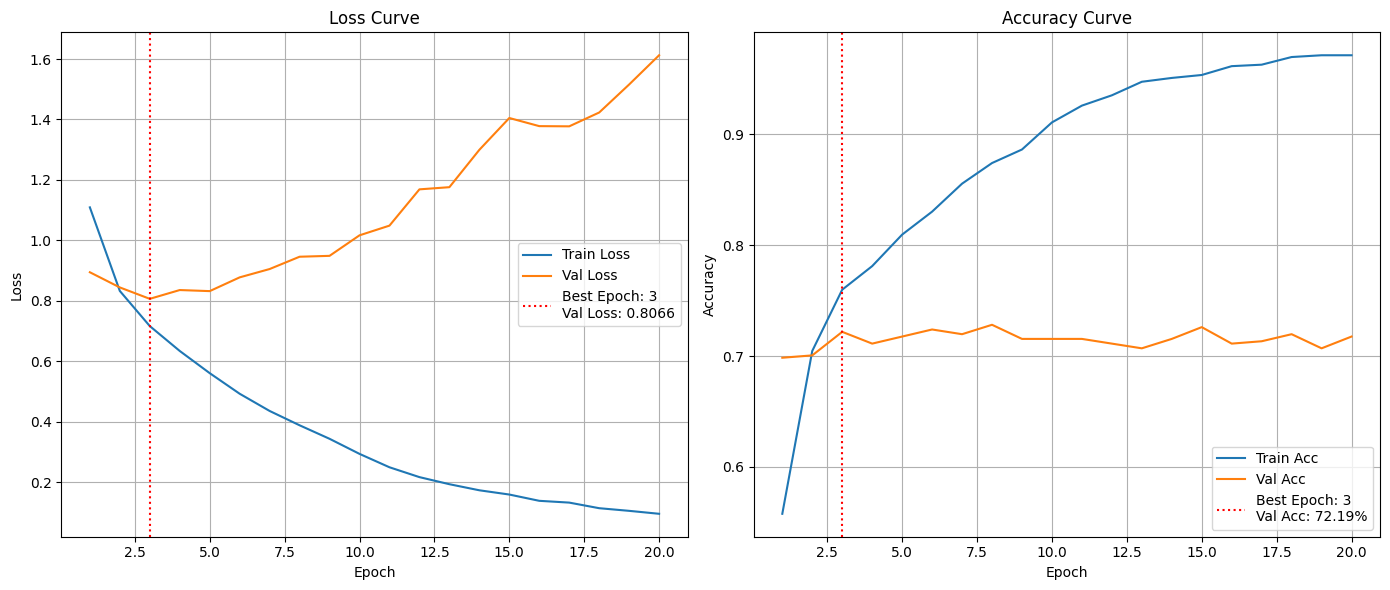

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       190
           1       0.60      0.59      0.59        94
           2       0.55      0.70      0.61        60
           3       0.77      0.72      0.75       127

    accuracy                           0.72       471
   macro avg       0.69      0.70      0.69       471
weighted avg       0.73      0.72      0.72       471



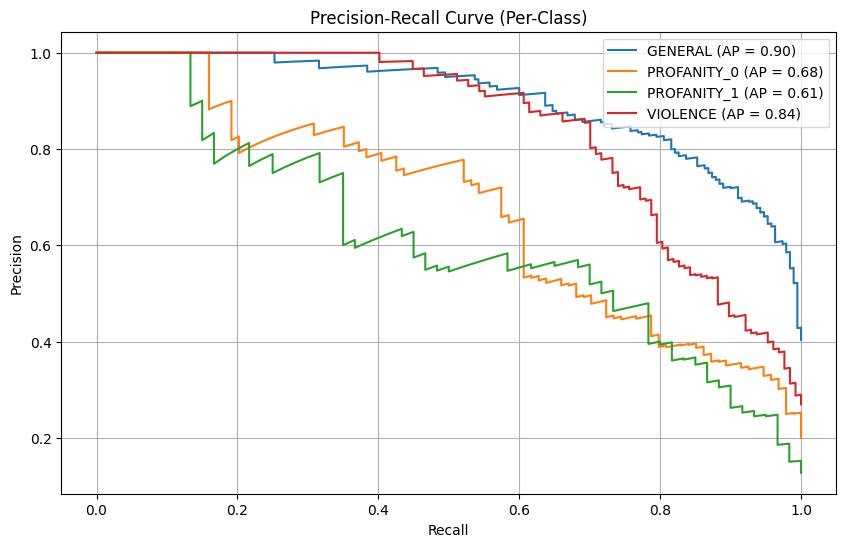

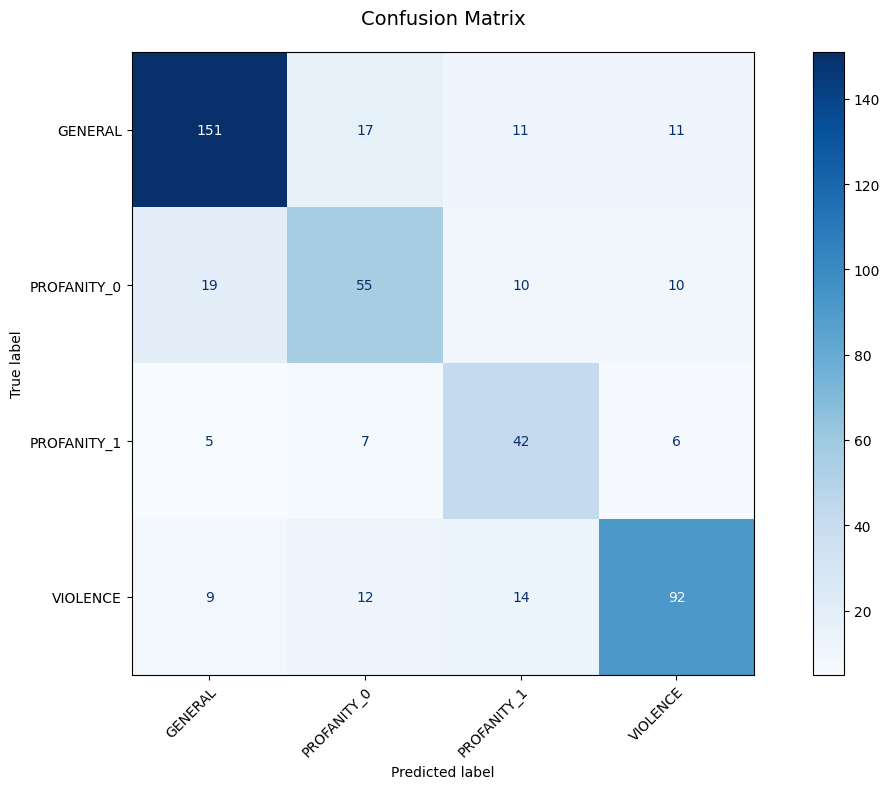

In [41]:
# pretrained
cs_pretrained_params = {
    "input_dim" : 300,
    "hidden_dim" : 148,
    "num_classes" : 4,
    "lr" : 1e-4,
    "weight_decay" : 1e-5,
    "train_batch_size" : 16,
    "test_batch_size" : 16,
    "val_batch_size" : 16,
    "dropout" : 0.5
}

cs_pretrained_model = BiLSTMAttention(
    input_dim=cs_pretrained_params["input_dim"],
    hidden_dim=cs_pretrained_params["hidden_dim"],
    num_classes=cs_pretrained_params["num_classes"]
).to(device)

# Loss function
cs_pretrained_criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer using unpacking
cs_pretrained_optimizer = torch.optim.AdamW(
    cs_pretrained_model.parameters(),
    lr=cs_pretrained_params["lr"],
    weight_decay=cs_pretrained_params["weight_decay"]
)

cs_pretrained_model = model_train(cs_pretrained_model, cs_pretrained_criterion, cs_pretrained_optimizer, pretrained_train_loader, pretrained_val_loader,save_name="cs_Word2Vec_pretrained", version_control=True,epochs= 20)
cs_pretrained_report = evaluate_model(cs_pretrained_model, pretrained_val_loader, label_map,  version_control= True, save_name = "cs_Word2Vec_pretrained")

Epoch 1/20 | Train Loss: 1.0272 | Val Loss: 0.8138 | Train Acc: 62.05% | Val Acc: 72.40%
Epoch 2/20 | Train Loss: 0.6996 | Val Loss: 0.6790 | Train Acc: 77.16% | Val Acc: 78.13%
Epoch 3/20 | Train Loss: 0.5721 | Val Loss: 0.6431 | Train Acc: 81.30% | Val Acc: 77.07%
Epoch 4/20 | Train Loss: 0.4852 | Val Loss: 0.6499 | Train Acc: 84.14% | Val Acc: 79.19%
Epoch 5/20 | Train Loss: 0.4328 | Val Loss: 0.5971 | Train Acc: 86.00% | Val Acc: 79.62%
Epoch 6/20 | Train Loss: 0.3754 | Val Loss: 0.6638 | Train Acc: 87.99% | Val Acc: 81.74%
Epoch 7/20 | Train Loss: 0.3455 | Val Loss: 0.6549 | Train Acc: 89.11% | Val Acc: 81.53%
Epoch 8/20 | Train Loss: 0.3073 | Val Loss: 0.6716 | Train Acc: 90.25% | Val Acc: 80.89%
Epoch 9/20 | Train Loss: 0.2760 | Val Loss: 0.6933 | Train Acc: 90.97% | Val Acc: 80.04%
Epoch 10/20 | Train Loss: 0.2481 | Val Loss: 0.7301 | Train Acc: 91.95% | Val Acc: 79.41%
Epoch 11/20 | Train Loss: 0.2294 | Val Loss: 0.7867 | Train Acc: 92.88% | Val Acc: 79.62%
Epoch 12/20 | Train

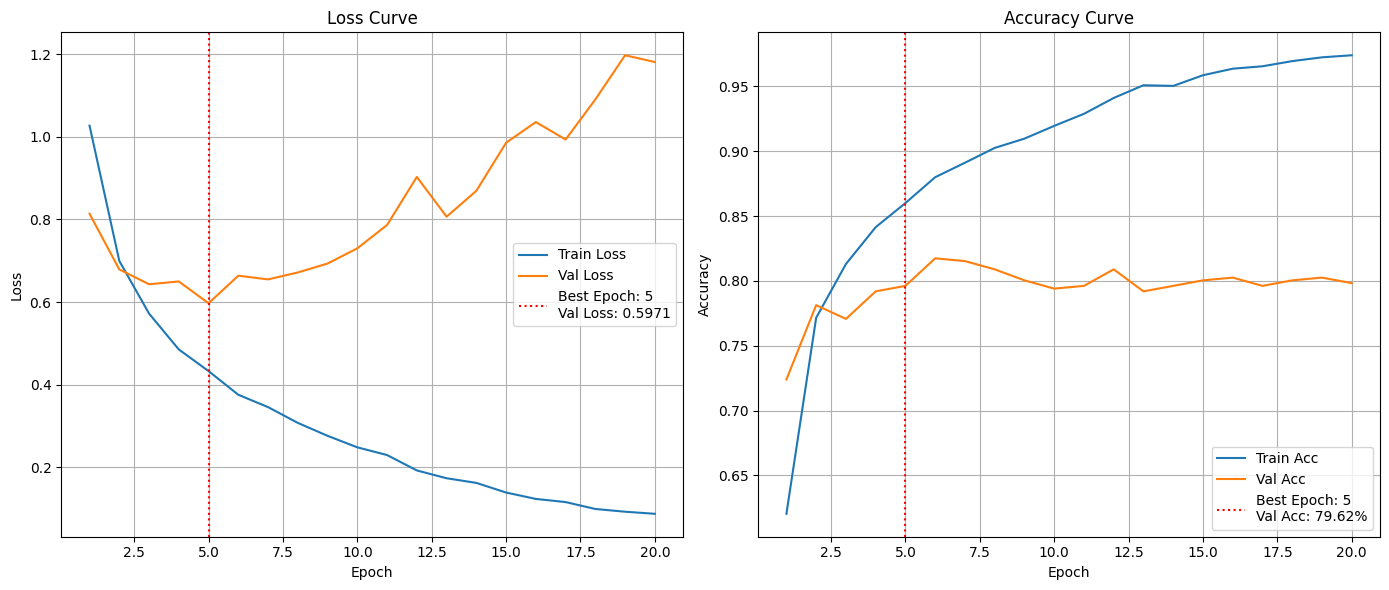

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85       190
           1       0.65      0.69      0.67        94
           2       0.77      0.83      0.80        60
           3       0.82      0.80      0.81       127

    accuracy                           0.80       471
   macro avg       0.78      0.79      0.78       471
weighted avg       0.80      0.80      0.80       471



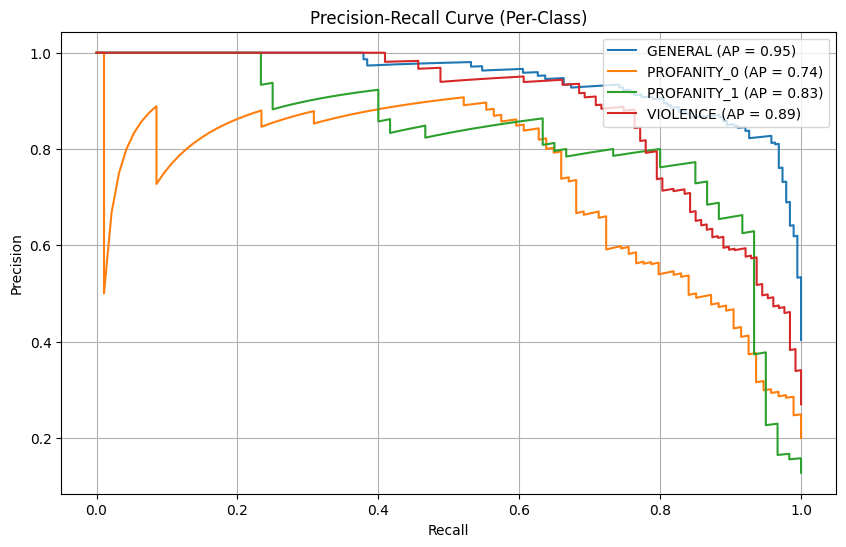

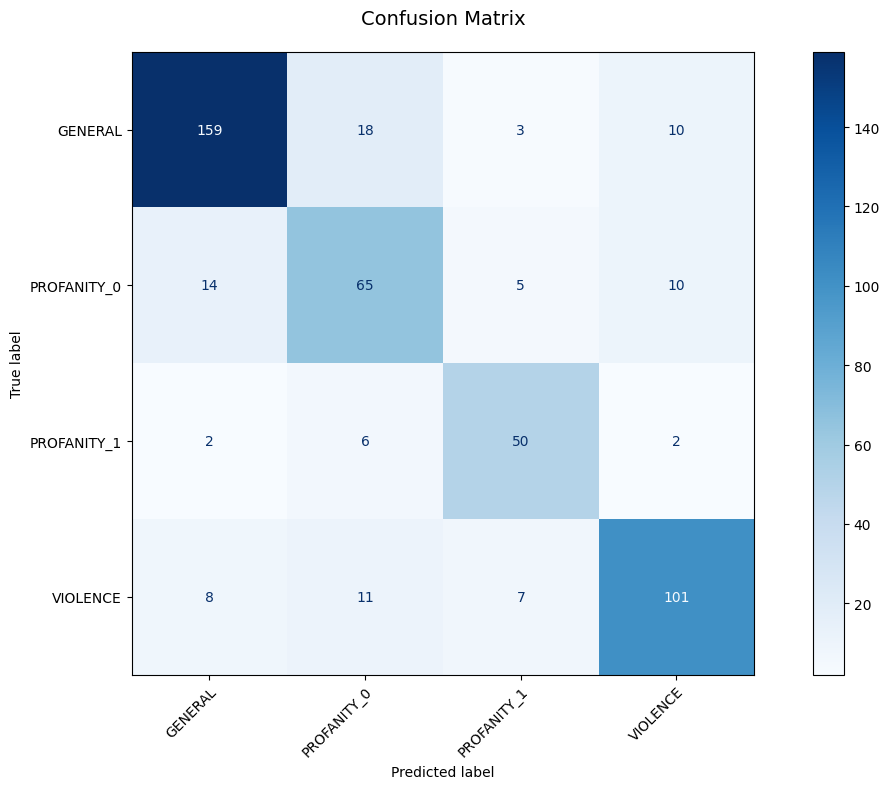

In [42]:
# finetuned
cs_finetuned_params = {
    "input_dim" : 300,
    "hidden_dim" : 148,
    "num_classes" : 4,
    "lr" : 1e-4,
    "weight_decay" : 1e-5,
    "train_batch_size" : 16,
    "test_batch_size" : 16,
    "val_batch_size" : 16,
    "dropout" : 0.5
}

cs_finetuned_model = BiLSTMAttention(
    input_dim=cs_finetuned_params["input_dim"],
    hidden_dim=cs_finetuned_params["hidden_dim"],
    num_classes=cs_finetuned_params["num_classes"]
).to(device)

# Loss function
cs_finetuned_criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer using unpacking
cs_finetuned_optimizer = torch.optim.AdamW(
    cs_finetuned_model.parameters(),
    lr=cs_finetuned_params["lr"],
    weight_decay=cs_finetuned_params["weight_decay"]
)

cs_finetuned_model = model_train(cs_finetuned_model, cs_finetuned_criterion, cs_finetuned_optimizer, finetuned_train_loader, finetuned_val_loader,save_name="cs_Word2Vec_finetuned", version_control=True,epochs= 20)
cs_finetuned_report = evaluate_model(cs_finetuned_model, finetuned_val_loader, label_map,  version_control= True, save_name = "cs_Word2Vec_finetuned")

## MLFlow logging

In [43]:
!pip install -q dagshub mlflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 53.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour

In [44]:
import dagshub
dagshub.init(repo_owner='tamangangel2057', repo_name='Nephased', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=4ef83346-2b58-4089-943a-1566494057ad&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=24f7f6c14d97212cd563e8735096fa343f16dcd45e8d09df7325f8f7a617f8a5




Accessing as tamangangel2057

Initialized MLflow to track repo "tamangangel2057/Nephased"

Repository tamangangel2057/Nephased initialized!

In [45]:
import mlflow

# Initialize Mlflow experiment
experiment = mlflow.get_experiment_by_name("Word_embedding_bilstm")
experiment_id = experiment.experiment_id
print(experiment_id)

0


In [46]:
# Start the run

torch.save(scratch_model.state_dict(), "scratch_model_state_dict.pt")

with mlflow.start_run(experiment_id=experiment_id, run_name="Word2Vec_scratch"):
    mlflow.log_params(scratch_params)
    mlflow.log_metrics({
        # Global accuracy
        "accuracy": scratch_report["accuracy"],

        # Per-class metrics (0 to 3)
        "precision_0": scratch_report["0"]["precision"],
        "recall_0": scratch_report["0"]["recall"],
        "f1_0": scratch_report["0"]["f1-score"],
        "support_0": scratch_report["0"]["support"],

        "precision_1": scratch_report["1"]["precision"],
        "recall_1": scratch_report["1"]["recall"],
        "f1_1": scratch_report["1"]["f1-score"],
        "support_1": scratch_report["1"]["support"],

        "precision_2": scratch_report["2"]["precision"],
        "recall_2": scratch_report["2"]["recall"],
        "f1_2": scratch_report["2"]["f1-score"],
        "support_2": scratch_report["2"]["support"],

        "precision_3": scratch_report["3"]["precision"],
        "recall_3": scratch_report["3"]["recall"],
        "f1_3": scratch_report["3"]["f1-score"],
        "support_3": scratch_report["3"]["support"],

        # Macro average
        "macro_precision": scratch_report["macro avg"]["precision"],
        "macro_recall": scratch_report["macro avg"]["recall"],
        "macro_f1": scratch_report["macro avg"]["f1-score"],
        "macro_support": scratch_report["macro avg"]["support"],

        # Weighted average
        "weighted_precision": scratch_report["weighted avg"]["precision"],
        "weighted_recall": scratch_report["weighted avg"]["recall"],
        "weighted_f1": scratch_report["weighted avg"]["f1-score"],
        "weighted_support": scratch_report["weighted avg"]["support"],
    })

    # Log all plots
    mlflow.log_artifact("/kaggle/working/Word2Vec_scratch_loss.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/Word2Vec_scratch_PR.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/Word2Vec_scratch_cm.png", artifact_path="plots")

    # Log weights
    mlflow.log_artifact("scratch_model_state_dict.pt", artifact_path="model")

🏃 View run Word2Vec_scratch at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/0/runs/793b7ac80b2c4a43abee090885812eb1
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/0


In [47]:
# Start the run

torch.save(pretrained_model.state_dict(), "pretrained_model_state_dict.pt")

with mlflow.start_run(experiment_id=experiment_id, run_name="Word2Vec_pretrained"):
    mlflow.log_params(pretrained_params)
    mlflow.log_metrics({
        # Global accuracy
        "accuracy": pretrained_report["accuracy"],

        # Per-class metrics (0 to 3)
        "precision_0": pretrained_report["0"]["precision"],
        "recall_0": pretrained_report["0"]["recall"],
        "f1_0": pretrained_report["0"]["f1-score"],
        "support_0": pretrained_report["0"]["support"],

        "precision_1": pretrained_report["1"]["precision"],
        "recall_1": pretrained_report["1"]["recall"],
        "f1_1": pretrained_report["1"]["f1-score"],
        "support_1": pretrained_report["1"]["support"],

        "precision_2": pretrained_report["2"]["precision"],
        "recall_2": pretrained_report["2"]["recall"],
        "f1_2": pretrained_report["2"]["f1-score"],
        "support_2": pretrained_report["2"]["support"],

        "precision_3": pretrained_report["3"]["precision"],
        "recall_3": pretrained_report["3"]["recall"],
        "f1_3": pretrained_report["3"]["f1-score"],
        "support_3": pretrained_report["3"]["support"],

        # Macro average
        "macro_precision": pretrained_report["macro avg"]["precision"],
        "macro_recall": pretrained_report["macro avg"]["recall"],
        "macro_f1": pretrained_report["macro avg"]["f1-score"],
        "macro_support": pretrained_report["macro avg"]["support"],

        # Weighted average
        "weighted_precision": pretrained_report["weighted avg"]["precision"],
        "weighted_recall": pretrained_report["weighted avg"]["recall"],
        "weighted_f1": pretrained_report["weighted avg"]["f1-score"],
        "weighted_support": pretrained_report["weighted avg"]["support"],
    })

    # Log all plots
    mlflow.log_artifact("/kaggle/working/Word2Vec_pretrained_loss.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/Word2Vec_pretrained_PR.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/Word2Vec_pretrained_cm.png", artifact_path="plots")

    # Log weights
    mlflow.log_artifact("pretrained_model_state_dict.pt", artifact_path="model")

🏃 View run Word2Vec_pretrained at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/0/runs/5826774920174e50845569ccf2a9a791
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/0


In [48]:
# Start the run

torch.save(finetuned_model.state_dict(), "finetuned_model_state_dict.pt")

with mlflow.start_run(experiment_id=experiment_id, run_name="Word2Vec_finetuned"):
    mlflow.log_params(finetuned_params)
    mlflow.log_metrics({
        # Global accuracy
        "accuracy": finetuned_report["accuracy"],

        # Per-class metrics (0 to 3)
        "precision_0": finetuned_report["0"]["precision"],
        "recall_0": finetuned_report["0"]["recall"],
        "f1_0": finetuned_report["0"]["f1-score"],
        "support_0": finetuned_report["0"]["support"],

        "precision_1": finetuned_report["1"]["precision"],
        "recall_1": finetuned_report["1"]["recall"],
        "f1_1": finetuned_report["1"]["f1-score"],
        "support_1": finetuned_report["1"]["support"],

        "precision_2": finetuned_report["2"]["precision"],
        "recall_2": finetuned_report["2"]["recall"],
        "f1_2": finetuned_report["2"]["f1-score"],
        "support_2": finetuned_report["2"]["support"],

        "precision_3": finetuned_report["3"]["precision"],
        "recall_3": finetuned_report["3"]["recall"],
        "f1_3": finetuned_report["3"]["f1-score"],
        "support_3": finetuned_report["3"]["support"],

        # Macro average
        "macro_precision": finetuned_report["macro avg"]["precision"],
        "macro_recall": finetuned_report["macro avg"]["recall"],
        "macro_f1": finetuned_report["macro avg"]["f1-score"],
        "macro_support": finetuned_report["macro avg"]["support"],

        # Weighted average
        "weighted_precision": finetuned_report["weighted avg"]["precision"],
        "weighted_recall": finetuned_report["weighted avg"]["recall"],
        "weighted_f1": finetuned_report["weighted avg"]["f1-score"],
        "weighted_support": finetuned_report["weighted avg"]["support"],
    })

    # Log all plots
    mlflow.log_artifact("/kaggle/working/Word2Vec_finetuned_loss.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/Word2Vec_finetuned_PR.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/Word2Vec_finetuned_cm.png", artifact_path="plots")

    # Log weights
    mlflow.log_artifact("finetuned_model_state_dict.pt", artifact_path="model")

🏃 View run Word2Vec_finetuned at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/0/runs/86b2c6904f1c406f90a62eb84e3dbae4
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/0


### saving cs models

In [49]:
# Start the run

torch.save(cs_scratch_model.state_dict(), "cs_scratch_model_state_dict.pt")

with mlflow.start_run(experiment_id=experiment_id, run_name="Word2Vec_cs_scratch"):
    mlflow.log_params(cs_scratch_params)
    mlflow.log_metrics({
        # Global accuracy
        "accuracy": cs_scratch_report["accuracy"],

        # Per-class metrics (0 to 3)
        "precision_0": cs_scratch_report["0"]["precision"],
        "recall_0": cs_scratch_report["0"]["recall"],
        "f1_0": cs_scratch_report["0"]["f1-score"],
        "support_0": cs_scratch_report["0"]["support"],

        "precision_1": cs_scratch_report["1"]["precision"],
        "recall_1": cs_scratch_report["1"]["recall"],
        "f1_1": cs_scratch_report["1"]["f1-score"],
        "support_1": cs_scratch_report["1"]["support"],

        "precision_2": cs_scratch_report["2"]["precision"],
        "recall_2": cs_scratch_report["2"]["recall"],
        "f1_2": cs_scratch_report["2"]["f1-score"],
        "support_2": cs_scratch_report["2"]["support"],

        "precision_3": cs_scratch_report["3"]["precision"],
        "recall_3": cs_scratch_report["3"]["recall"],
        "f1_3": cs_scratch_report["3"]["f1-score"],
        "support_3": cs_scratch_report["3"]["support"],

        # Macro average
        "macro_precision": cs_scratch_report["macro avg"]["precision"],
        "macro_recall": cs_scratch_report["macro avg"]["recall"],
        "macro_f1": cs_scratch_report["macro avg"]["f1-score"],
        "macro_support": cs_scratch_report["macro avg"]["support"],

        # Weighted average
        "weighted_precision": cs_scratch_report["weighted avg"]["precision"],
        "weighted_recall": cs_scratch_report["weighted avg"]["recall"],
        "weighted_f1": cs_scratch_report["weighted avg"]["f1-score"],
        "weighted_support": cs_scratch_report["weighted avg"]["support"],
    })

    # Log all plots
    mlflow.log_artifact("/kaggle/working/cs_Word2Vec_scratch_loss.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/cs_Word2Vec_scratch_PR.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/cs_Word2Vec_scratch_cm.png", artifact_path="plots")

    # Log weights
    mlflow.log_artifact("cs_scratch_model_state_dict.pt", artifact_path="model")

    # Saving the class weights as params too
    for idx, weight in enumerate(class_weights_tensor.tolist()):
        mlflow.log_param(f"class_weight_{idx}", weight)

🏃 View run Word2Vec_cs_scratch at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/0/runs/8a2b64b6816c4f7e823e599ba87d57ea
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/0


In [50]:
# Start the run

torch.save(cs_pretrained_model.state_dict(), "cs_pretrained_model_state_dict.pt")

with mlflow.start_run(experiment_id=experiment_id, run_name="Word2Vec_cs_pretrained"):
    mlflow.log_params(cs_pretrained_params)
    mlflow.log_metrics({
        # Global accuracy
        "accuracy": cs_pretrained_report["accuracy"],

        # Per-class metrics (0 to 3)
        "precision_0": cs_pretrained_report["0"]["precision"],
        "recall_0": cs_pretrained_report["0"]["recall"],
        "f1_0": cs_pretrained_report["0"]["f1-score"],
        "support_0": cs_pretrained_report["0"]["support"],

        "precision_1": cs_pretrained_report["1"]["precision"],
        "recall_1": cs_pretrained_report["1"]["recall"],
        "f1_1": cs_pretrained_report["1"]["f1-score"],
        "support_1": cs_pretrained_report["1"]["support"],

        "precision_2": cs_pretrained_report["2"]["precision"],
        "recall_2": cs_pretrained_report["2"]["recall"],
        "f1_2": cs_pretrained_report["2"]["f1-score"],
        "support_2": cs_pretrained_report["2"]["support"],

        "precision_3": cs_pretrained_report["3"]["precision"],
        "recall_3": cs_pretrained_report["3"]["recall"],
        "f1_3": cs_pretrained_report["3"]["f1-score"],
        "support_3": cs_pretrained_report["3"]["support"],

        # Macro average
        "macro_precision": cs_pretrained_report["macro avg"]["precision"],
        "macro_recall": cs_pretrained_report["macro avg"]["recall"],
        "macro_f1": cs_pretrained_report["macro avg"]["f1-score"],
        "macro_support": cs_pretrained_report["macro avg"]["support"],

        # Weighted average
        "weighted_precision": cs_pretrained_report["weighted avg"]["precision"],
        "weighted_recall": cs_pretrained_report["weighted avg"]["recall"],
        "weighted_f1": cs_pretrained_report["weighted avg"]["f1-score"],
        "weighted_support": cs_pretrained_report["weighted avg"]["support"],
    })

    # Log all plots
    mlflow.log_artifact("/kaggle/working/cs_Word2Vec_pretrained_loss.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/cs_Word2Vec_pretrained_PR.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/cs_Word2Vec_pretrained_cm.png", artifact_path="plots")

    # Log weights
    mlflow.log_artifact("cs_pretrained_model_state_dict.pt", artifact_path="model")

    # Saving the class weights as params too
    for idx, weight in enumerate(class_weights_tensor.tolist()):
        mlflow.log_param(f"class_weight_{idx}", weight)

🏃 View run Word2Vec_cs_pretrained at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/0/runs/d263d09dd2fb4e0a96a62a01bc1b03c3
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/0


In [51]:
# Start the run

torch.save(cs_finetuned_model.state_dict(), "cs_finetuned_model_state_dict.pt")

with mlflow.start_run(experiment_id=experiment_id, run_name="Word2Vec_cs_finetuned"):
    mlflow.log_params(cs_finetuned_params)
    mlflow.log_metrics({
        # Global accuracy
        "accuracy": cs_finetuned_report["accuracy"],

        # Per-class metrics (0 to 3)
        "precision_0": cs_finetuned_report["0"]["precision"],
        "recall_0": cs_finetuned_report["0"]["recall"],
        "f1_0": cs_finetuned_report["0"]["f1-score"],
        "support_0": cs_finetuned_report["0"]["support"],

        "precision_1": cs_finetuned_report["1"]["precision"],
        "recall_1": cs_finetuned_report["1"]["recall"],
        "f1_1": cs_finetuned_report["1"]["f1-score"],
        "support_1": cs_finetuned_report["1"]["support"],

        "precision_2": cs_finetuned_report["2"]["precision"],
        "recall_2": cs_finetuned_report["2"]["recall"],
        "f1_2": cs_finetuned_report["2"]["f1-score"],
        "support_2": cs_finetuned_report["2"]["support"],

        "precision_3": cs_finetuned_report["3"]["precision"],
        "recall_3": cs_finetuned_report["3"]["recall"],
        "f1_3": cs_finetuned_report["3"]["f1-score"],
        "support_3": cs_finetuned_report["3"]["support"],

        # Macro average
        "macro_precision": cs_finetuned_report["macro avg"]["precision"],
        "macro_recall": cs_finetuned_report["macro avg"]["recall"],
        "macro_f1": cs_finetuned_report["macro avg"]["f1-score"],
        "macro_support": cs_finetuned_report["macro avg"]["support"],

        # Weighted average
        "weighted_precision": cs_finetuned_report["weighted avg"]["precision"],
        "weighted_recall": cs_finetuned_report["weighted avg"]["recall"],
        "weighted_f1": cs_finetuned_report["weighted avg"]["f1-score"],
        "weighted_support": cs_finetuned_report["weighted avg"]["support"],
    })

    # Log all plots
    mlflow.log_artifact("/kaggle/working/cs_Word2Vec_finetuned_loss.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/cs_Word2Vec_finetuned_PR.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/cs_Word2Vec_finetuned_cm.png", artifact_path="plots")

    # Log weights
    mlflow.log_artifact("cs_finetuned_model_state_dict.pt", artifact_path="model")

    # Saving the class weights as params too
    for idx, weight in enumerate(class_weights_tensor.tolist()):
        mlflow.log_param(f"class_weight_{idx}", weight)

🏃 View run Word2Vec_cs_finetuned at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/0/runs/2595317236c14cbcac54f01923927cc6
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/0
